In [1]:
import numpy as np
from scipy import signal as sig
import librosa
from src.synth import Synth
import matplotlib.pyplot as plt



def three_step_envelope(signal, K=200, freq_cutoff=0.125, padlen=150):
    # Take the absolute value of the signal
    abs_signal = np.abs(signal)

    # Split signal into K bunches of N/K samples and take the max
    # value from each bunch
    N = len(abs_signal)
    peaks = []
    for i in range(0, N, K):
        peaks.append(np.max(abs_signal[i:i+K]))
    peaks = np.asarray(peaks)

    # Apply a LPF with a cut off of 0.125 Times the Niquist (125 Hz)
    b, a = sig.butter(8, freq_cutoff)
    lpf_peaks = sig.filtfilt(b, a, peaks, padlen=padlen)
    
    return lpf_peaks

def find_first_onset(signal, K=200):
    onsets = []
    while len(onsets) == 0: 
        approx_env = three_step_envelope(signal=signal, K=K)
        # convert envelope to Fortran-contiguous
        ftrn_env = np.asfortranarray(approx_env) 

        onsets = librosa.onset.onset_detect(y=ftrn_env, sr=sr)
        print(onsets)
        K-=10
    
    return onsets[0]

def attack(signal, onset, sr):
    '''
    Computes attack time by taking the difference 
    of the argmax and onset and dividing by the sampling rate
    '''
    return (np.argmax(np.abs(signal)) - onset)/sr

def extract_envelope(signal, sr):
    '''
    Approximate envelope, Extract attack
    '''
    K = 200
    approx_env = three_step_envelope(signal=signal, K=K)
    # convert envelope to Fortran-contiguous
    ftrn_env = np.asfortranarray(approx_env) 
    
    first_onset = find_first_onset(signal)
    attack_t = attack(ftrn_env, first_onset, sr)
    
    return {
        "attack": attack_t,
        "decay": 0.5,
        "sustain": (1.0, 0.5),
        "release": 2.0,
    }

In [2]:
import soundfile as sf

fname = '../datasets/guitar/open-e.wav'
signal, sr = sf.read(fname)
synth.set_signal(signal)
synth.set_srate(sr)
env = synth.extract_envelope()

[5]


In [13]:
import ipywidgets as widgets

synth = Synth()

# Initialize sliders
attack = widgets.FloatSlider(
    description='attack:',
    value=env['attack'],
    min=0,
    max=2.0,
    step=0.00001,
    readout_format='.4f',
)
decay = widgets.FloatSlider(
    description='decay:',
    value=env['decay'],
    min=0,
    max=2.0,
    step=0.00001,
    readout_format='.4f',
)
sustain_time = widgets.FloatSlider(
    description='sustain time:',
    value=env['sustain'][0],
    min=0,
    max=10,
    step=0.00001,
    readout_format='.4f',
)
sustain_power = widgets.FloatSlider(
    description='sustain power:',
    value=env['sustain'][1],
    min=0,
    max=1.0,
    step=0.00001,
    readout_format='.4f',
)
release = widgets.FloatSlider(
    description='release:',
    value=env['release'],
    min=0,
    max=10,
    step=0.00001,
    readout_format='.4f',
)
ui = widgets.VBox([attack, decay, sustain_time, sustain_power, release])

def f(attack, decay, sustain_time, sustain_power, release):
    env = {
        "attack": attack,
        "decay": decay,
        "sustain": (sustain_time, sustain_power),
        "release": release
    }
    synth.set_envelope(env)
    print(synth.get_envelope())
    # construct envelope

out = widgets.interactive_output(
    f, {'attack': attack, 'decay': decay, 'sustain_time': sustain_time,
        'sustain_power': sustain_power, 'release': release}
)

display(ui, out)

Output()

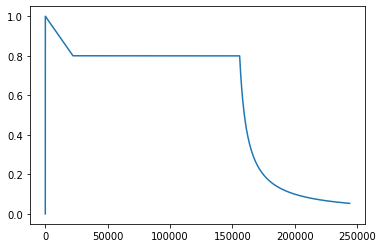

In [16]:
plt.plot(synth.envelope_amp_track()[0])